<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Descente-de-Gradient-Stochastique" data-toc-modified-id="Descente-de-Gradient-Stochastique-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Descente de Gradient Stochastique</a></span></li><li><span><a href="#Mini-batch" data-toc-modified-id="Mini-batch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Mini-batch</a></span></li></ul></div>

Descente de Gradient Stochastique
===========================

La [Descente de Gradient Stochastique](http://en.wikipedia.org/wiki/Stochastic_gradient_descent) est une variante  [stochastique](http://en.wikipedia.org/wiki/Stochastic) de la descente de gradient, qui permet d'utiliser un algorithme efficace pour minimiser les fonctions de coût sous la forme d'une somme:

$$
  Q(\mathbf{w}) = \sum_{i=1}^{d} Q_i(\mathbf{w}) \; ,
$$

où $\mathbf{w}$ est un vecteur de paramètres (ou poids) à optimiser. La composante $Q_i$ est la contribution du $i$ème échantillon au coût total $Q$, qui est ce que l'on cherche précisémment à minimiser en utilisantun ensemble d'entraînement de $d$ échantillons.

En utilisant la descente de gradient standard, $Q$ peut être minimisée par l'itération suivante:

$\begin{eqnarray*}
  \mathbf{w}_{t+1} &=& \mathbf{w}_t - \eta \nabla Q \\
   &=& \mathbf{w}_t - \eta \sum_{i=1}^{d} \nabla Q_i(\mathbf{w}_t) \; ,\\
  \end{eqnarray*}$

où $\eta > 0$ est la taille du *pas*. Cette méthode d'itération par traitement de lots (*batch*) permet de calculer le coût total à chaque pas avec un temps de calcul qui est proportionnel à la taille $d$ de l'ensemble d'entraînement.

De manière similaire, dans la descente de gradient stochastique, $Q$ est minimisée en utilisant

$$
  \mathbf{w}_{t+1} = \mathbf{w}_t - \eta \nabla Q_i (\mathbf{w}_t) \; ,
$$

en mettant à jour les poids $\mathbf{w}$ à chaque itération en utilisant juste un échantillon $i$ choisi aléatoirement de l'ensemble d'entraînement. Ceci est extrêmement efficace pour les grandes tailles d'échantillons, parce que cela permet d'obtenir un temps de calcul de chaque itération indépendant de $d$. Un autre avantage est que cela permet de traiter les échantillons à la volée, comme  une tâche d'[apprentissage en ligne](http://en.wikipedia.org/wiki/Online_machine_learning).

En pratique, au lieu d'un $\eta$ fixé, l'algorithme décroît la taille du pas  $\eta_t$ pour améliorer la convergence.

On va implémenter une version avec pas constant.

In [1]:
import torch
import torch.utils.data
import numpy as np

Dans cette implémentation $Q_i$ a la forme



$$Q_i(\mathbf{w}) = \left\Vert \mathbf{y}_i - f_{\mathbf{w}} (\mathbf{x}_i) \right\Vert \; ,$$


où $f_{\mathbf{w}} : \mathbb{R}^n \to \mathbb{R}^m$  est une fonction *modèle* pour notre jeu de données, paramétrisée par $\mathbf{w}$; $\mathbf{x}_i \in \mathbb{R}^n$ et $\mathbf{y}_i \in \mathbb{R}^m$ sont la paire d'entrées/sorties pour l'$i$ème échantillon de l'ensemble d'apprentissage. Trouver les paramètres $\mathbf{w}$ qui minimisent $Q(\mathbf{w}) = \sum_{i=1}^{d} Q_i (\mathbf{w})$ et qui ajuste la fonction modèle $f_{\mathbf{w}}$ à nos données.



On va le tester grâce à l'[ajustement de courbe](http://en.wikipedia.org/wiki/Curve_fitting)(*curve fitting*) suivante :



$$f_{\mathbf{w}} (x) = w_1 x^2 + w_2 x + w_3$$

In [2]:
def f(w,x):
    return w[0] * x * x + w[1] * x + w[2]

Commençons par définir notre jeu de données

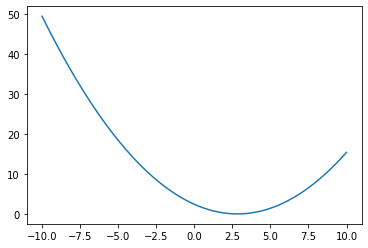

In [3]:
wt = [0.3,-1.7,2.5] # Ce sont les paramètres que l'on va essayer de retrouver
xtrain = np.arange(-10,10,0.01,dtype='f')
ytrain = (lambda x : f(wt,x))(xtrain)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(xtrain,ytrain);

Pour traiter notre ensemble d'entraînement il faut mettre ensemble entrées(*input*) et sorties(*target*), via la fonction `concatenate`.

In [4]:
xtrainnp = np.array([xtrain])
ytrainnp = np.array([ytrain])
dataTconcat = np.concatenate((xtrainnp,ytrainnp))
points = np.transpose(dataTconcat)
points

array([[-10.      ,  49.5     ],
       [ -9.99    ,  49.423027],
       [ -9.98    ,  49.346115],
       ...,
       [  9.970457,  15.373228],
       [  9.980457,  15.416082],
       [  9.990458,  15.458996]], dtype=float32)

On initialise les paramètres $w$

In [5]:
w0 = torch.zeros(3,requires_grad=True)

Dans une première version de la *SGD* naïve, on va itérer sur tous les échantillons et incrémenter notre vecteur de poids sur chacun d'eux.

On aura une fonction :
```python
def sgd(f,w,t,eta=0.00001, epsilon=0.001,nepoch=100):
```
où `eta` est la taille du pas, `epsilon` la limite de convergence du coût, et `nepoch` le nombre maximum de fois où l'on aura parcouru tous les échantillons.

### Exercice 1

Compléter le code ci-dessous pour faire une descente de gradient

In [6]:
# Installer tqdm et éventuellement ipywidgets
# from tqdm import tqdm # Si pas ipywidgets
from tqdm.notebook import tqdm 

def sgd(f,w,t,eta=0.0001, epsilon=0.01,nepoch=20):
    bar = tqdm(total=nepoch) # 
    epoch = 0
    x = t[:,0]
    y = t[:,1]
    while(epoch < nepoch):
        loss = torch.mean(torch.pow(y-f(w,x),2))
        loss.backward()
        w.data.sub_(eta * w.grad)
        w.grad.data.zero_()
        bar.update() # Affichage
        bar.set_description("loss %f" % loss.item())
        epoch += 1
        if (loss.item() < epsilon):
            print("convergence au bout de %i epochs." % epoch)
            break

In [7]:
w0 = torch.zeros(3,requires_grad=True)
sgd(f,w0,torch.tensor(points),eta=0.0002,epsilon=0.1,nepoch=10000)

convergence au bout de 9340 epochs.


On vérifie que l'on s'est rapproché des paramètres du modèle.

In [8]:
print(wt)
print(w0)
torch.norm(torch.tensor(wt)-w0)

[0.3, -1.7, 2.5]
tensor([ 0.3079, -1.7000,  2.0258], requires_grad=True)


tensor(0.4743, grad_fn=<NormBackward0>)

### Exercice 2

Légère simplification, utiliser la fonction de coût toute faite `torch.nn.MSELoss()`
```python
criterion = torch.nn.MSELoss()
```

Ecrire la version du sgd avec cette fonction de coût "prête à l'emploi"

In [9]:
def sgd(f,w,t,eta=0.0001, epsilon=0.01,nepoch=20):
    bar = tqdm(total=nepoch) # 
    epoch = 0
    criterion = torch.nn.MSELoss()
    x = t[:,0]
    y = t[:,1]
    while(epoch < nepoch):
        loss = criterion(f(w,x),y)
        loss.backward()
        w.data.sub_(eta * w.grad)
        w.grad.data.zero_()
        bar.update() # Affichage
        bar.set_description("loss %f" % loss.item())
        epoch += 1
        if (loss.item() < epsilon):
            print("convergence au bout de %i epochs." % epoch)
            break

In [10]:
w0 = torch.zeros(3,requires_grad=True)
sgd(f,w0,torch.tensor(points),eta=0.0002,epsilon=0.1,nepoch=10000)

convergence au bout de 9340 epochs.


# Mini-batch

On va maintenant mettre en placer la vraie version *minibatch* du SGD.
Pour ce faire, on utilise directement les facilités du [`DataLoader`](https://pytorch.org/docs/stable/data.html)  de `pytorch`, qui combine un jeu de données et un échantilloneur.

In [11]:
trainloader = torch.utils.data.DataLoader(points,batch_size=10,shuffle=True)

### Exercice 3

énumérer tous les éléments de chaque batch avec le print suivant

In [12]:
for i, data in enumerate(trainloader):
    for j, (x,y) in enumerate(data):
        print("batch %i, échantillon %i : x = %f, y = %f" % (i,j,x.item(),y.item()))

batch 0, échantillon 0 : x = 3.510309, y = 0.229156
batch 0, échantillon 1 : x = -9.249983, y = 43.893627
batch 0, échantillon 2 : x = 2.140278, y = 0.235765
batch 0, échantillon 3 : x = -8.979977, y = 41.957954
batch 0, échantillon 4 : x = 4.960342, y = 1.448917
batch 0, échantillon 5 : x = 7.360397, y = 6.239960
batch 0, échantillon 6 : x = -3.819859, y = 13.371156
batch 0, échantillon 7 : x = -1.329802, y = 5.291174
batch 0, échantillon 8 : x = -7.129934, y = 29.871677
batch 0, échantillon 9 : x = 4.600334, y = 1.028354
batch 1, échantillon 0 : x = 1.030252, y = 1.066997
batch 1, échantillon 1 : x = 6.460377, y = 4.038300
batch 1, échantillon 2 : x = -3.149843, y = 10.831187
batch 1, échantillon 3 : x = 3.090300, y = 0.111476
batch 1, échantillon 4 : x = -4.659878, y = 16.936131
batch 1, échantillon 5 : x = -2.069818, y = 7.303936
batch 1, échantillon 6 : x = 9.640450, y = 13.992716
batch 1, échantillon 7 : x = 1.870272, y = 0.369913
batch 1, échantillon 8 : x = -3.899860, y = 13.69

batch 19, échantillon 5 : x = 3.810316, y = 0.378015
batch 19, échantillon 6 : x = 7.950411, y = 7.947011
batch 19, échantillon 7 : x = 7.100391, y = 5.554002
batch 19, échantillon 8 : x = 7.730406, y = 7.286063
batch 19, échantillon 9 : x = 1.790270, y = 0.418061
batch 20, échantillon 0 : x = -8.849974, y = 41.041565
batch 20, échantillon 1 : x = -8.729971, y = 40.204670
batch 20, échantillon 2 : x = 0.810247, y = 1.319530
batch 20, échantillon 3 : x = 4.270327, y = 0.711152
batch 20, échantillon 4 : x = -5.199890, y = 19.451471
batch 20, échantillon 5 : x = -2.439827, y = 8.433533
batch 20, échantillon 6 : x = -3.989862, y = 14.058468
batch 20, échantillon 7 : x = -7.619946, y = 32.872978
batch 20, échantillon 8 : x = 9.750452, y = 14.445625
batch 20, échantillon 9 : x = -5.459896, y = 20.724964
batch 21, échantillon 0 : x = -0.479782, y = 3.384687
batch 21, échantillon 1 : x = 2.490286, y = 0.126971
batch 21, échantillon 2 : x = -9.809996, y = 48.047798
batch 21, échantillon 3 : x =

batch 47, échantillon 2 : x = 3.480309, y = 0.217240
batch 47, échantillon 3 : x = 0.480240, y = 1.752781
batch 47, échantillon 4 : x = 9.160439, y = 12.101345
batch 47, échantillon 5 : x = -4.809881, y = 17.617285
batch 47, échantillon 6 : x = 2.860294, y = 0.091884
batch 47, échantillon 7 : x = -6.329916, y = 25.281208
batch 47, échantillon 8 : x = 6.500378, y = 4.125832
batch 47, échantillon 9 : x = 8.840431, y = 10.917233
batch 48, échantillon 0 : x = 8.520424, y = 9.794566
batch 48, échantillon 1 : x = -8.079956, y = 35.821632
batch 48, échantillon 2 : x = -7.739948, y = 33.629951
batch 48, échantillon 3 : x = 5.930365, y = 2.969148
batch 48, échantillon 4 : x = 4.790339, y = 1.240627
batch 48, échantillon 5 : x = 9.120438, y = 11.949971
batch 48, échantillon 6 : x = -0.569784, y = 3.566029
batch 48, échantillon 7 : x = -2.899837, y = 9.952441
batch 48, échantillon 8 : x = 9.000435, y = 11.501610
batch 48, échantillon 9 : x = -5.269892, y = 19.790344
batch 49, échantillon 0 : x = 

batch 76, échantillon 0 : x = -6.639923, y = 27.014442
batch 76, échantillon 1 : x = -5.219891, y = 19.547993
batch 76, échantillon 2 : x = 4.970343, y = 1.461709
batch 76, échantillon 3 : x = 9.070436, y = 11.762104
batch 76, échantillon 4 : x = -7.029932, y = 29.276869
batch 76, échantillon 5 : x = -8.709970, y = 40.066029
batch 76, échantillon 6 : x = -8.749971, y = 40.343552
batch 76, échantillon 7 : x = 6.560379, y = 4.258927
batch 76, échantillon 8 : x = 4.250326, y = 0.694027
batch 76, échantillon 9 : x = 4.700336, y = 1.137377
batch 77, échantillon 0 : x = -0.589785, y = 3.606988
batch 77, échantillon 1 : x = 6.170370, y = 3.432410
batch 77, échantillon 2 : x = -7.449942, y = 31.815392
batch 77, échantillon 3 : x = 4.180325, y = 0.635983
batch 77, échantillon 4 : x = -6.259914, y = 24.897814
batch 77, échantillon 5 : x = -9.639992, y = 46.766819
batch 77, échantillon 6 : x = -8.289961, y = 37.209969
batch 77, échantillon 7 : x = 5.380352, y = 2.037858
batch 77, échantillon 8 : 

batch 103, échantillon 7 : x = 6.770384, y = 4.741777
batch 103, échantillon 8 : x = 9.800453, y = 14.653894
batch 103, échantillon 9 : x = 5.840363, y = 2.804335
batch 104, échantillon 0 : x = -3.559853, y = 12.353516
batch 104, échantillon 1 : x = -7.259937, y = 30.653902
batch 104, échantillon 2 : x = 0.320236, y = 1.986364
batch 104, échantillon 3 : x = -3.429850, y = 11.859905
batch 104, échantillon 4 : x = -2.169821, y = 7.601132
batch 104, échantillon 5 : x = 5.510355, y = 2.241601
batch 104, échantillon 6 : x = -2.459827, y = 8.496932
batch 104, échantillon 7 : x = -5.999908, y = 23.499516
batch 104, échantillon 8 : x = 5.520355, y = 2.257692
batch 104, échantillon 9 : x = -9.679993, y = 47.066666
batch 105, échantillon 0 : x = 5.870363, y = 2.858731
batch 105, échantillon 1 : x = -3.349848, y = 11.561186
batch 105, échantillon 2 : x = -6.779926, y = 27.816097
batch 105, échantillon 3 : x = 1.680267, y = 0.490535
batch 105, échantillon 4 : x = 9.220440, y = 12.330207
batch 105,

batch 131, échantillon 4 : x = -9.519989, y = 45.873039
batch 131, échantillon 5 : x = 8.200417, y = 8.733341
batch 131, échantillon 6 : x = -4.909883, y = 18.078888
batch 131, échantillon 7 : x = -7.299938, y = 30.896626
batch 131, échantillon 8 : x = 8.250418, y = 8.895108
batch 131, échantillon 9 : x = 4.420330, y = 0.847234
batch 132, échantillon 0 : x = -7.999954, y = 35.299702
batch 132, échantillon 1 : x = 9.420444, y = 13.108679
batch 132, échantillon 2 : x = -8.879974, y = 41.252144
batch 132, échantillon 3 : x = -0.499783, y = 3.424565
batch 132, échantillon 4 : x = -3.619854, y = 12.584755
batch 132, échantillon 5 : x = -2.689833, y = 9.243276
batch 132, échantillon 6 : x = 0.390238, y = 1.882281
batch 132, échantillon 7 : x = 6.600380, y = 4.348860
batch 132, échantillon 8 : x = 7.240395, y = 5.918324
batch 132, échantillon 9 : x = -1.419804, y = 5.518419
batch 133, échantillon 0 : x = -6.029909, y = 23.658787
batch 133, échantillon 1 : x = -0.989794, y = 4.476557
batch 133

batch 167, échantillon 7 : x = 0.670244, y = 1.495353
batch 167, échantillon 8 : x = -4.619877, y = 16.756769
batch 167, échantillon 9 : x = -3.419849, y = 11.822355
batch 168, échantillon 0 : x = 1.580265, y = 0.562721
batch 168, échantillon 1 : x = -6.469919, y = 26.056820
batch 168, échantillon 2 : x = -2.729834, y = 9.376314
batch 168, échantillon 3 : x = -3.629854, y = 12.623506
batch 168, échantillon 4 : x = -7.069933, y = 29.514072
batch 168, échantillon 5 : x = -8.139957, y = 36.215599
batch 168, échantillon 6 : x = 6.620380, y = 4.394184
batch 168, échantillon 7 : x = 2.590288, y = 0.109388
batch 168, échantillon 8 : x = -0.579784, y = 3.586478
batch 168, échantillon 9 : x = 2.240280, y = 0.197180
batch 169, échantillon 0 : x = -8.679970, y = 39.858513
batch 169, échantillon 1 : x = -7.799950, y = 34.011681
batch 169, échantillon 2 : x = 8.820431, y = 10.845267
batch 169, échantillon 3 : x = -9.179981, y = 43.387589
batch 169, échantillon 4 : x = 4.750338, y = 1.194138
batch 1

### Exercice 4

Réécrire la descente de gradient version mini-batch en utilisant le `trainloader`.
Attention pour le calcul du coût il faut maintenant cumuler sur tous les batch à chaque époque. Bien réfléchir à la bonne stratégie.

In [13]:
def sgd(f,w,t,eta=0.0001, epsilon=0.01,nepoch=200,minibatch=10):
    epoch = 0    
    bar = tqdm(total=nepoch)
    criterion = torch.nn.MSELoss()
    trainloader = torch.utils.data.DataLoader(t,batch_size=minibatch,shuffle=True)
    while(epoch < nepoch):
        running_loss = 0.
        for data in trainloader:
            x , y = data[:,0],data[:,1]
            loss = criterion(f(w,x),y)
            loss.backward()
            w.data.sub_(eta * w.grad)
            w.grad.data.zero_()
            running_loss = running_loss + loss.item() * len(data)
        running_loss = running_loss / len(t)
        bar.update()
        bar.set_description("loss %f" % running_loss)
        epoch += 1
        if (running_loss < epsilon):
            print("convergence au bout de %i epochs." % epoch)
            break

In [14]:
w0 = torch.zeros(3,requires_grad=True)
sgd(f,w0,torch.tensor(points),eta=0.0002,epsilon=0.1,nepoch=50)

convergence au bout de 48 epochs.


In [15]:
print(wt)
print(w0)
torch.norm(torch.tensor(wt)-w0)

[0.3, -1.7, 2.5]
tensor([ 0.3058, -1.6994,  2.0479], requires_grad=True)


tensor(0.4521, grad_fn=<NormBackward0>)

Maintenant il nous reste plus qu'à utiliser les optimiseurs de [`torch.optim`](https://pytorch.org/docs/stable/optim.html) comme `Adam`, `RMSProp` etc.

il faut charger l'optimiseur avec les paramètres $w$
```python
optimizer = torch.optim.Adam([w], lr=lr)
```

Après chaque rétropropagation, on peut appeler `optimizer.step()`: cela mettra effecturea directement le "pas" de descente et remet à zéro les gradients, on n'a plus besoin de le faire.

### Exercice 5

Version du sgd avec l'optimiseur RMSprop.

In [16]:
def sgd(f,w,t,lr=0.01, epsilon=0.01,nepoch=200,minibatch=10):
    epoch = 0
    bar = tqdm(total=nepoch)
    optimizer = torch.optim.RMSprop([w], lr=lr)
    trainloader = torch.utils.data.DataLoader(t,batch_size=minibatch,shuffle=True)
    criterion = torch.nn.MSELoss()
    while (epoch < nepoch):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            optimizer.zero_grad()
            x, y = data[:,0],data[:,1]
            loss = criterion(f(w,x),y)
            running_loss = running_loss + loss.item() * len(data)
            loss.backward()
            optimizer.step()
        running_loss = running_loss / len(t)
        bar.update()
        bar.set_description("loss %f" % running_loss)
        epoch += 1
        if (loss.item() < epsilon):
            print("convergence au bout de %i itérations." % epoch)
            break

In [17]:
w0 = torch.zeros(3,requires_grad=True)
sgd(f,w0,torch.tensor(points),epsilon=1e-7,nepoch=50)

convergence au bout de 31 itérations.


In [18]:
print(wt)
print(w0)
torch.norm(torch.tensor(wt)-w0)

[0.3, -1.7, 2.5]
tensor([ 0.3000, -1.7000,  2.4998], requires_grad=True)


tensor(0.0002, grad_fn=<NormBackward0>)

### Exercice 6

Réessayer les sgd avec l'option shuffle=False dans le trainloader. Que constatez-vous ? Quelle explication ?

### Exercice 7

- Comparer dans la sgd la fonction de coût $L(X,Y)$ sur l'ensemble des points avec la somme des fonctions de coûts des batchs $\sum{L(X_i,Y_i)}$ déj). Comment expliquer la différence ? Est-ce grave docteur ? (indice, penser à l'inégalité triangulaire)
- Même question mais pour la norme du gradient.